# Baseline proportions

For each percentile, get the expected ratio of counts - that is, according to the baseline counts for all words, the proportion of the words that are expected to fall into each bucket.

In [1]:
y1 = 1800
y2 = 1920

In [2]:
from lint.models import Offset

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

In [3]:
baseline_counts = Offset.baseline_series(y1, y2)

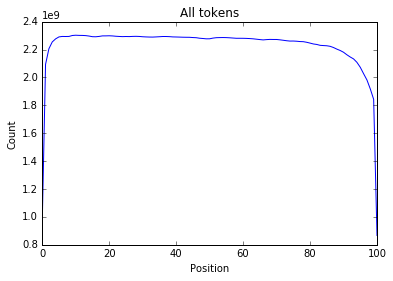

In [4]:
plt.title('All tokens')
plt.xlabel('Position')
plt.ylabel('Count')
plt.plot(*zip(*baseline_counts.items()))
plt.show()

In [5]:
total_count = sum(baseline_counts.values())

baseline_ratios = {
    offset: count / total_count
    for offset, count in baseline_counts.items()
}

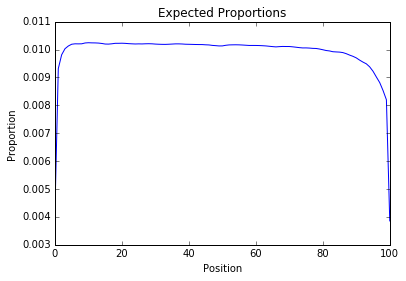

In [6]:
plt.title('Expected Proportions')
plt.xlabel('Position')
plt.ylabel('Proportion')
plt.plot(*zip(*baseline_ratios.items()))
plt.show()

# Expected vs. observed

Now, for any given token, we can plot the actual series against the series that would be expected based on the overall count for the token.

In [7]:
def plot_expected_vs_observed(token):
    
    observed = Offset.token_series(token, y1, y2)
    
    total_count = sum(observed.values())

    expected = {
        offset: baseline_ratios[offset] * total_count
        for offset, count in observed.items()
    }
    
    print(token)
    
    plt.title('Expected vs. Observed')
    plt.xlabel('Offset')
    plt.ylabel('Count')
    plt.plot(*zip(*expected.items()), color='gray')
    plt.plot(*zip(*observed.items()))
    plt.show()

the


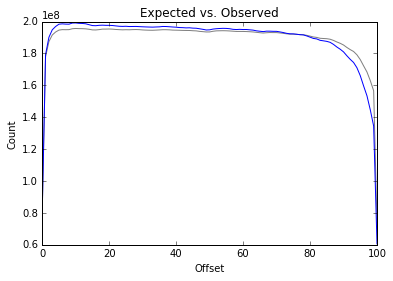

she


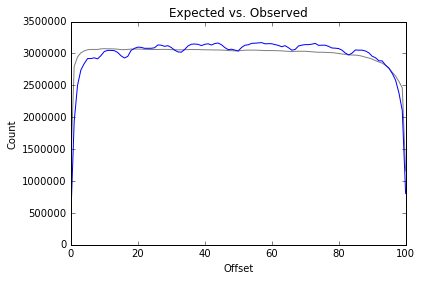

her


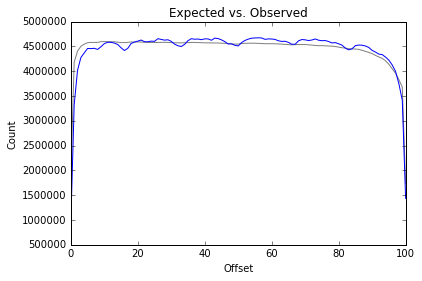

library


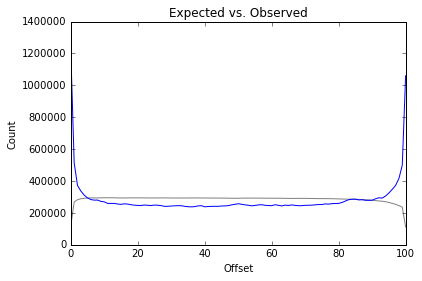

early


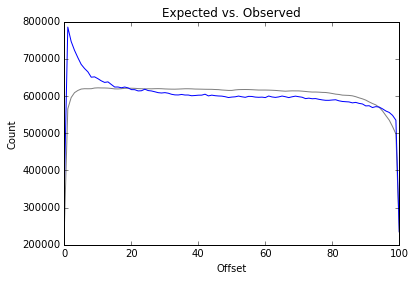

In [8]:
plot_expected_vs_observed('the')
plot_expected_vs_observed('she')
plot_expected_vs_observed('her')
plot_expected_vs_observed('library')
plot_expected_vs_observed('early')

# Observed minus expected

The raw, euclidean distance beween the observed value and the expected.

In [9]:
def plot_observed_minus_expected(token):
    
    observed = Offset.token_series(token, y1, y2)
    
    total_count = sum(observed.values())

    delta = {
        offset: observed[offset] - (baseline_ratios[offset] * total_count)
        for offset, count in observed.items()
    }
    
    print(token)
    
    plt.title('Observed - Expected')
    plt.xlabel('Offset')
    plt.ylabel('Count')
    plt.plot(*zip(*delta.items()))
    plt.show()

the


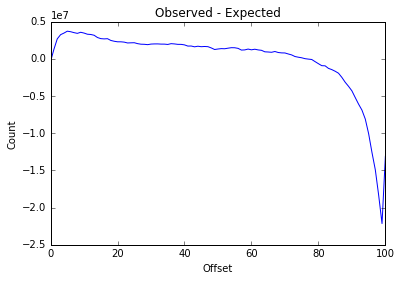

she


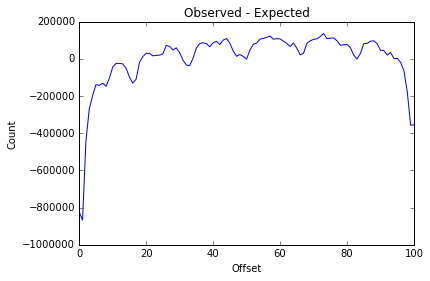

her


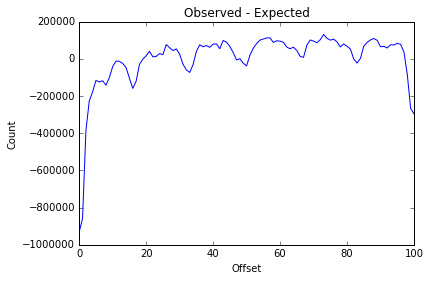

library


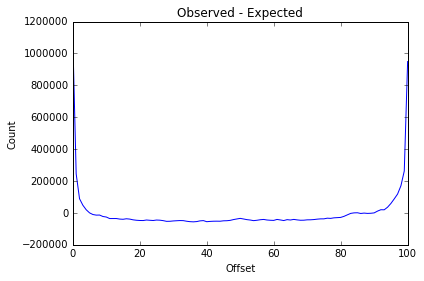

early


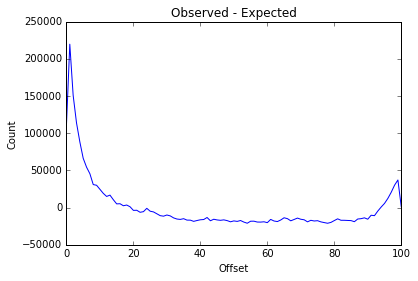

In [10]:
plot_observed_minus_expected('the')
plot_observed_minus_expected('she')
plot_observed_minus_expected('her')
plot_observed_minus_expected('library')
plot_observed_minus_expected('early')

In [21]:
from collections import OrderedDict
from sklearn.preprocessing import scale

def plot_observed_minus_expected_scaled(token):
    
    observed = Offset.token_series(token, y1, y2)
    
    total_count = sum(observed.values())

    delta = OrderedDict([
        (offset, observed[offset] - (baseline_ratios[offset] * total_count))
        for offset, count in observed.items()
    ])
    
    scaled = scale(list(delta.values()))
    
    delta_scaled = OrderedDict([
        (offset, value)
        for offset, value in zip(delta.keys(), scaled)
    ])
    
    plt.title('Observed - Expected')
    plt.xlabel('Offset')
    plt.ylabel('Count')
    plt.plot(*zip(*delta_scaled.items()))
    plt.show() 

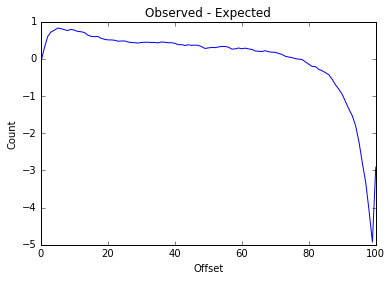

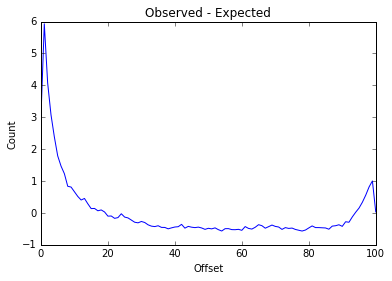

In [23]:
plot_observed_minus_expected_scaled('the')
plot_observed_minus_expected_scaled('early')
plot_observed_minus_expected_scaled('the')

# Per-offset variance

In [24]:
counts = Offset.token_counts(y1, y2)

In [25]:
# Tokens with >1M occurrences.
tokens = [token for token, count in counts.items() if count > 1e7]

In [47]:
from collections import defaultdict

deltas = defaultdict(list)

for token in tokens:
    
    observed = Offset.token_series(token, y1, y2)
    
    total_count = sum(observed.values())

    delta = OrderedDict([
        (offset, observed[offset] - (baseline_ratios[offset] * total_count))
        for offset, count in observed.items()
    ])
    
    # TODO: Is this a valid way to normalize the distance from expected?
    scaled = scale(list(delta.values()))
    
    delta_scaled = OrderedDict([
        (offset, value)
        for offset, value in zip(delta.keys(), scaled)
    ])
    
    for offset, scaled in delta_scaled.items():
        deltas[offset].append(scaled)

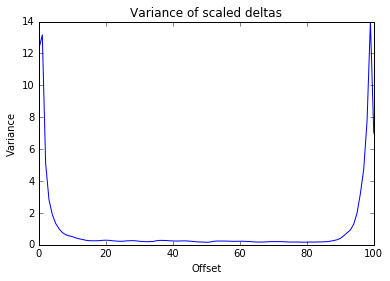

In [48]:
import numpy as np

delta_var = {
    offset: np.var(values)
    for offset, values in list(deltas.items())
}

plt.title('Variance of scaled deltas')
plt.xlabel('Offset')
plt.ylabel('Variance')
plt.plot(*zip(*delta_var.items()))
plt.show() 

The extreme signatures of the front/end matter drown out everything else, but, if we chop them off:

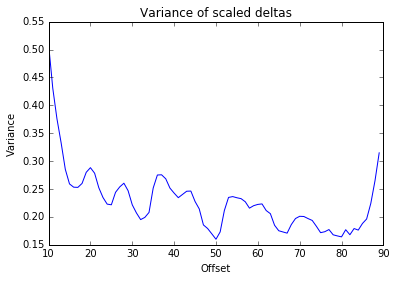

In [46]:
# 10% -> 90%
trimmed = list(delta_var.items())[10:90]

plt.title('Variance of scaled deltas')
plt.xlabel('Offset')
plt.ylabel('Variance')
plt.plot(*zip(*trimmed))
plt.show() 

Dip at exactly the 50% mark, two humps on either side?